In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from settings import DATA_DIR, MODEL_DIR
from src.utils import transform

# Load data into memory

In [2]:
file = os.path.join(DATA_DIR, 'era5_west_pacific_sst.nc')
ds = xr.open_dataset(file)
arr = ds['sst'].mean(dim='expver')[:, ::2, ::2]  # Half resolution
ds.close()

Text(0, 0.5, 'lat')

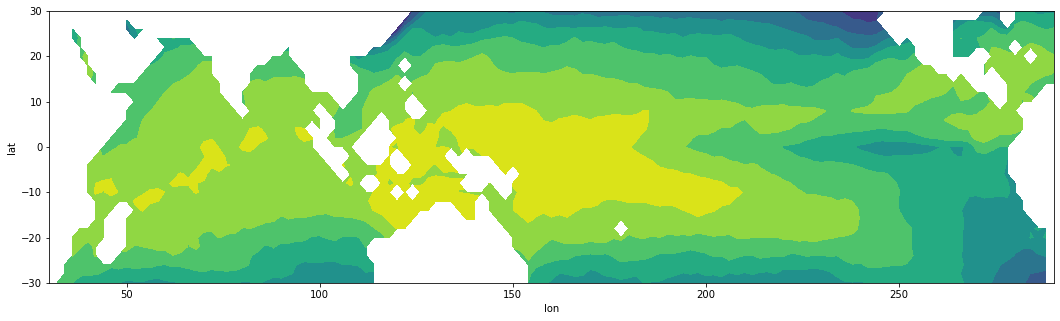

In [3]:
plt.figure(figsize=[18, 5])
plt.contourf(arr.coords['longitude'], arr.coords['latitude'], arr[0, :, :])
plt.xlabel('lon')
plt.ylabel('lat')

# Seasonality and trend removal

In [4]:
doy = arr.coords['time'].dt.dayofyear

# Calculate seasonal mean
means = arr.groupby(doy).mean()

test = means.isel(longitude=12, latitude=12)

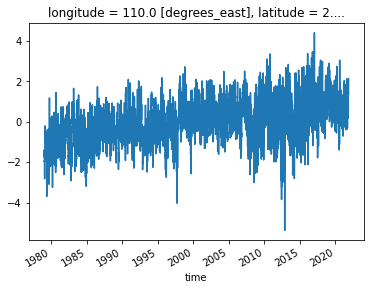

In [5]:
rem_seas = transform.SeasonalityRemoverFFT(div_std=True, fft_keep_frac=0.03).fit(arr)
deseas = rem_seas.transform(arr)

i, j = 14, 40
deseas[:, i, j].plot()

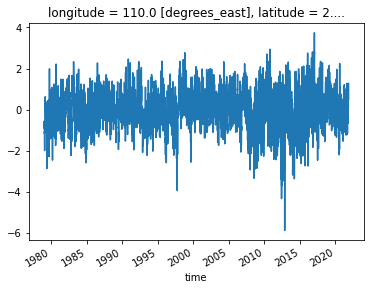

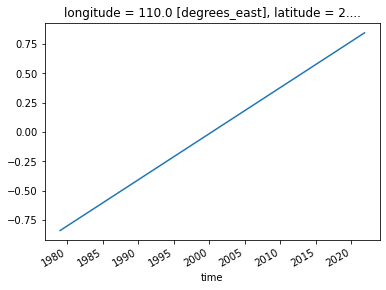

In [9]:
rem_trend = transform.TrendRemover().fit(deseas)
detr = rem_trend.transform(deseas)

detr[:, i, j].plot()
plt.show()
(deseas - detr)[:, i, j].plot()
plt.show()

Text(0, 0.5, 'lat')

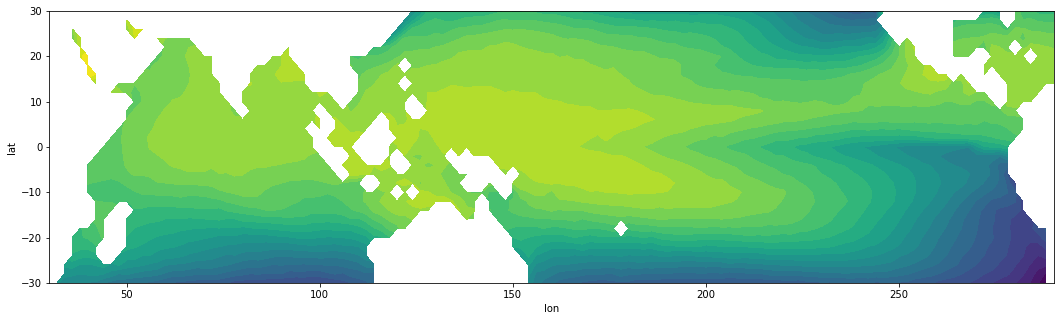

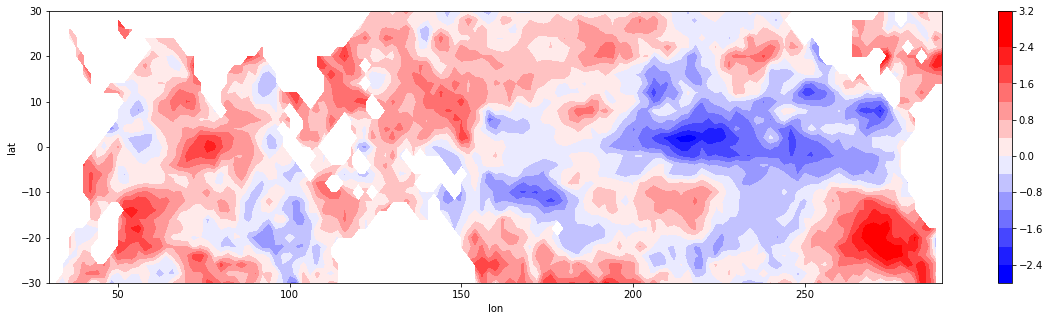

In [12]:
plt.figure(figsize=[18, 5])
plt.contourf(deseas.coords['longitude'], deseas.coords['latitude'], rem_seas.get_means().sel(dayofyear=deseas.coords['time'].dayofyear)[300, :, :], cmap='viridis', levels=25)
plt.xlabel('lon')
plt.ylabel('lat')

plt.figure(figsize=[20, 5])
c = plt.contourf(detr.coords['longitude'], detr.coords['latitude'], detr[850, :, :], cmap='bwr', vmin=-2.5, vmax=2.5, levels=15)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')

# PCA

We'll need to flatten all the arrays and get rid of NaNs. We want to do this in such a way that we can easily transform back into the grid shape (for visualization). 

Text(0, 0.5, 'lat')

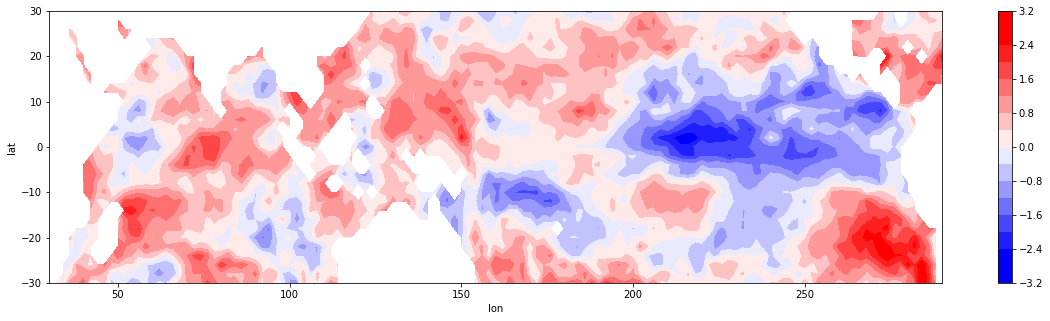

In [49]:
df_tfm = transform.DataArray2DataFrame().fit(detr)
df_detr = df_tfm.transform(detr)

detr_copy = df_tfm.inverse_transform(df_detr.dropna(how='all', axis=1))   
plt.figure(figsize=[20, 5])
c = plt.contourf(detr_copy.coords['longitude'], detr_copy.coords['latitude'], detr_copy[850:855, :, :].mean(axis=0), cmap='bwr', vmin=-2.5, vmax=2.5, levels=15)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat') 

In [194]:
from scipy.linalg import svd

df_detr_drop = df_detr.dropna(how='all', axis=1)
cov_matrix = df_detr_drop.T @ df_detr_drop
ef, ev, eft = svd(cov_matrix)


Text(0, 0.5, 'lat')

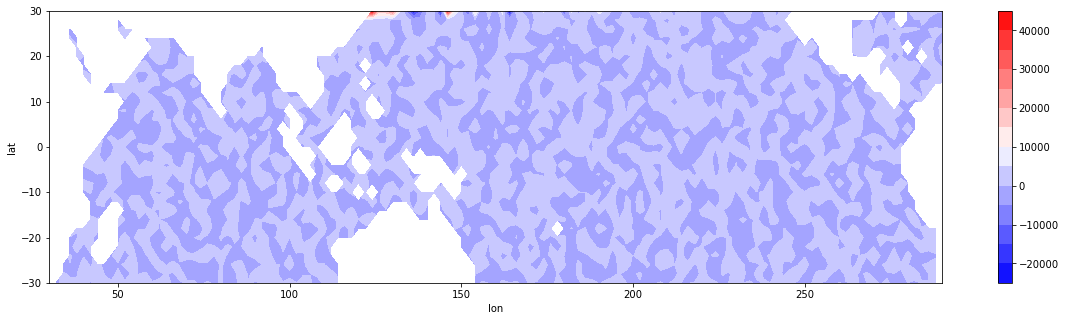

In [214]:
eofs = pd.DataFrame(
    data=ef * ev, 
    index=np.arange(ev.shape[0]), 
    columns=df_detr_drop.columns
).reindex(df_detr.columns, axis=1)

eofs_da = df_tfm.inverse_transform(eofs)
# eofs_da.coords['time'].rename('component')

plt.figure(figsize=[20, 5])
c = plt.contourf(eofs_da.coords['longitude'], eofs_da.coords['latitude'], eofs_da[15, :, :], cmap='bwr', levels=15)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat') 
# from itertools import product
# list(product(detr.coords['longitude'].values, detr.coords['latitude'].values))

In [104]:
orig_shape = arr.shape
flat_shape = (arr.shape[0], arr.shape[1] * arr.shape[2])

flat_detr = detr.values.reshape(flat_shape)


In [114]:
np.sum(~np.isnan(flat_detr), axis=0) > 0

array([False, False, False, ...,  True,  True, False])

('time', 'latitude', 'longitude')